In [1]:
'''
This Jupyter Notebook contains the utility function, load_plot, and a series of pyplot snippets,
which generate all of the figures used in the Project Mittens paper.

Author:       James Parkington
Created Date: 2023-03-31
'''

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn

from matplotlib.cm     import ScalarMappable
from matplotlib.colors import Normalize
from scipy.optimize    import curve_fit

def load_plot(figsize = (10, 6)):
    '''
    Applies a custom dark style and common customizations to a pyplot visualization
    and returns the pyplot, Axes, and color palette objects.

    Args:
        figsize (tuple, optional): The width and height of the figure in inches. Defaults to (10, 6).

    Returns:
        matplotlib.pyplot:     The pyplot object.
        matplotlib.axes.Axes:  The customized axes object.
        seaborn.color_palette: The color palette.
    '''

    plt.style.use(['seaborn-v0_8-darkgrid'])
    plt.rcParams.update({"xtick.labelsize"       : 8,
                         "ytick.labelsize"       : 8,
                         "grid.linestyle"        : ":",
                         "font.family"           : "DejaVu Sans Mono", 
                         "axes.titleweight"      : "bold",
                         "axes.labelweight"      : "bold",
                         "figure.figsize"        : figsize,
                         "legend.loc"            : "upper right",
                         "legend.fontsize"       : 8,
                         "legend.title_fontsize" : 10})
    
    _, ax = plt.subplots()
    ax.spines[:].set_visible(False)
    plt.tight_layout()

    return plt, ax, seaborn.color_palette('pastel') + seaborn.color_palette('husl')


'''
This snippet below processes and consolidates a series of FIDE rating files from the years 1971 to 2023.
These files contain the Standard FIDE ratings of all registered players for each year, recorded in January.

The data comes from two sources:
- Files from 2000 and earlier are provided by Mark Weeks       (https://www.mark-weeks.com/chess/ratings/)
- Files after 2000 are obtained from the official FIDE website (https://ratings.fide.com/download.phtml)

All the files from those sources have been converted into CSVs with the Player, Country, and Ratings fields extracted from their various schemas.

Author:       James Parkington
Created Date: 4/21/23
'''

import pandas as pd
import glob   as g

files = []
for file in g.glob("FIDE/Data/CSVs/*.csv"):
    files.append(pd.read_csv(file).assign(Year = file[-8:-4]))

fide_ratings = pd.concat(files)

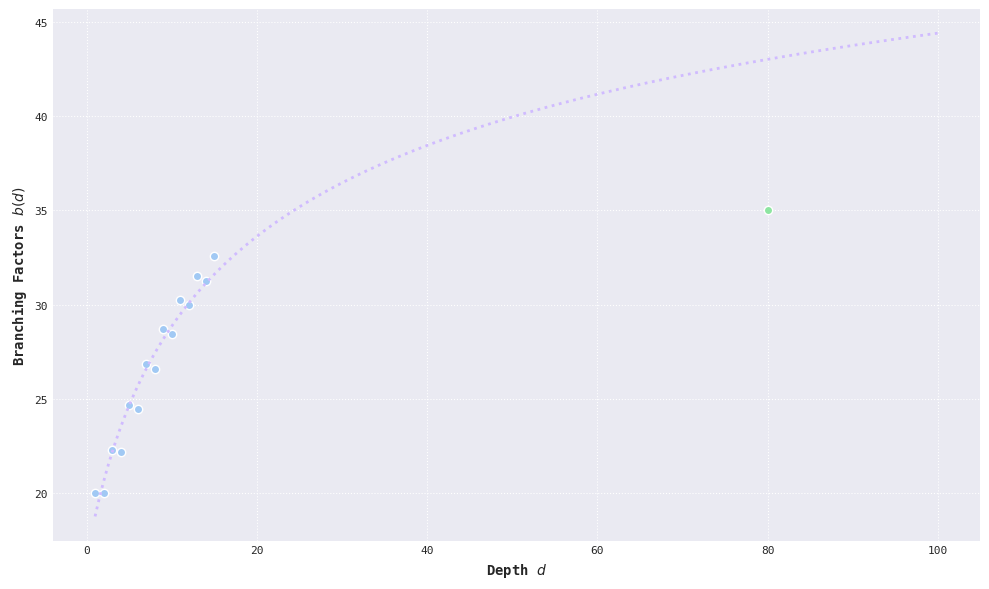

In [2]:
'''
Branching Factors (b(d) vs. d)
Visualizes the relationship between the depth (number of half-moves) in a game of chess
and the branching factor using a scatter plot and a custom curve fit line.

The script captures the diminishing returns of exploring deeper into the game tree due to 
the increasing number of possible moves, resulting in a logarithmic relationship between 
depth and branching factor.
'''

plt, ax, colors = load_plot()

# Prepare the data
depths    = np.array(list(range(1, 16)) + [80])
branching = np.array([20, 20, 22.255, 22.161, 24.663, 24.470, 26.843, 26.596, 28.701, 28.429, 30.246, 29.964, 31.518, 31.238, 32.562, 42.5], dtype = float)

# Define a custom logarithmic function
def custom_log(x, a, b, c, d):
    return a * np.log(x - c) ** b + d

# Fit the custom curve
depth_range = np.linspace(1, 100, 1000)
predictions = custom_log(depth_range, *curve_fit(custom_log, 
                                                 depths, 
                                                 branching,
                                                 maxfev = 100000,
                                                 p0 = (20, 1, 0, 0))[0])

# Create the scatter plot
plt.scatter(depths[:-1],    # Ignore the data pad at the end of the series
            branching[:-1], # Ignore the data pad at the end of the series
            color      = colors[0],
            marker     = 'o',
            edgecolors = 'white',
            label      = "Branching Factor")

# Isolate the point for the "Allis Estimate"
plt.scatter(np.array([80]),
            np.array([35]),
            color      = colors[2],
            marker     = 'o',
            edgecolors = 'white',
            label      = "Allis Estimate")

# Create the fit line
plt.plot(depth_range,
         predictions,
         color     = colors[4],
         linestyle = ':',
         linewidth = 2,
         label     = "Logarithmic Fit")

plt.xlabel("Depth $d$")
plt.ylabel("Branching Factors $b(d)$")
plt.tight_layout()

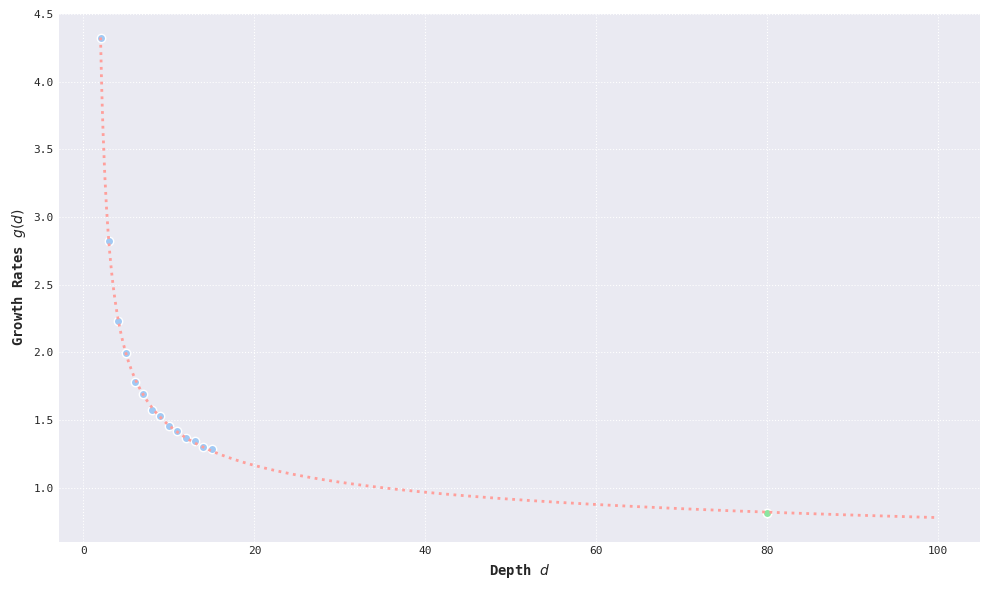

In [3]:
'''
Growth Rates (g(d) vs. d)
Visualizes the relationship between the depth (d) and the g(d) values using a scatter plot
and a logarithmic fit line.

This script demonstrates how to use curve fitting with a custom factorial function
to model the relationship between growth rates and depth (d) of moves in chess.
'''

plt, ax, colors = load_plot()

# Prepare the data
depths      = np.array(list(range(2, 16)) + [80])
g_values    = np.array([4.322, 2.824, 2.235, 1.992, 1.785, 1.691, 1.578, 1.528, 1.454, 1.422, 1.368, 1.345, 1.304, 1.286, 0.811])

# Define a custom logarithmic function
def custom_log(x, a, b, c, d):
    return a * (x ** b) / (x ** c + d)

# Fit the custom curve
depth_range = np.linspace(2, 100, 1000)
predictions = custom_log(depth_range, *curve_fit(custom_log, 
                                                 depths, 
                                                 g_values, 
                                                 maxfev = 100000, 
                                                 p0 = (1, -1, 1, 0))[0])

# Create the scatter plot
plt.scatter(depths,   
            g_values,   
            color      = colors[0], 
            marker     = 'o', 
            edgecolors = 'white', 
            label      = "Growth Rate")

# Isolate the point for the "Allis Estimate"
plt.scatter(np.array([80]),
            np.array([0.811]),
            color      = colors[2],
            marker     = 'o',
            edgecolors = 'white',
            label      = "Allis Estimate")

# Create the fit line
plt.plot(depth_range, 
         predictions, 
         color     = colors[3], 
         linestyle = ':', 
         linewidth = 2,       
         label     = "Logarithmic Fit")

plt.xlabel("Depth $d$")
plt.ylabel("Growth Rates $g(d)$")
plt.tight_layout()

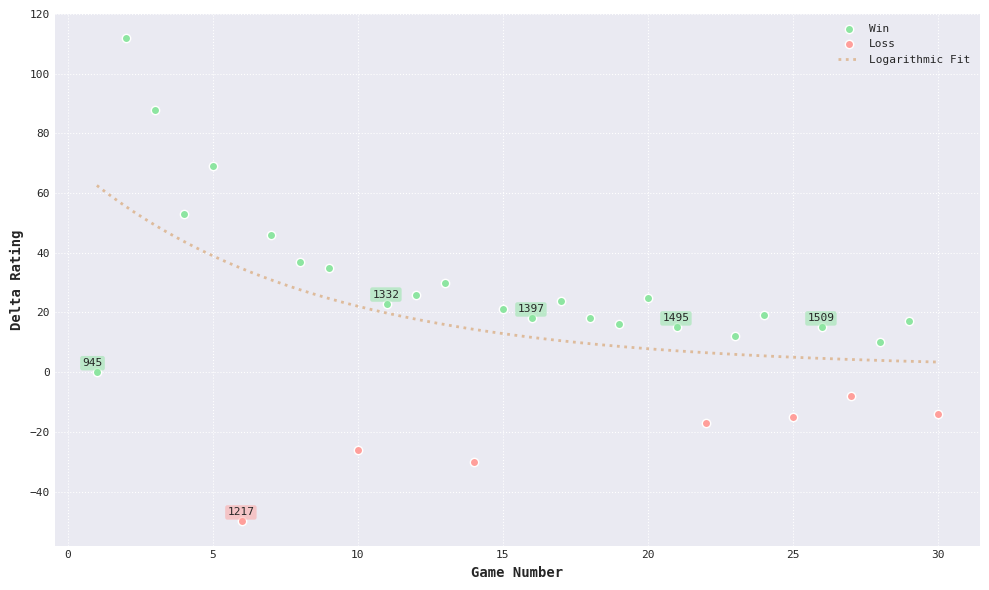

In [4]:
'''
Delta Rating vs. Game Number
Visualizes Player A's rating change, win/loss status, and opponent rating
in the first 30 games on a new chess account using a scatter plot.
'''

plt, ax, colors = load_plot()

# Prepare the data
game_numbers  = list(range(1, 31))
delta_ratings = [0, 112, 88, 53, 69, -50, 46, 37, 35, -26, 23, 26, 30, -30, 21, 18, 24, 18, 16, 25, 15, -17, 12, 19, -15, 15, -8, 10, 17, -14]
win_loss      = [2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3]
ratings       = [945, 1057, 1145, 1198, 1267, 1217, 1263, 1300, 1335, 1309, 1332, 1358, 1388, 1358, 1379, 1397, 1421, 1439, 1455, 1480, 1495, 1478, 1490, 1509, 1494, 1509, 1501, 1511, 1528, 1514]

def custom_log(x, a, b, c, d):
    return a * np.log(x - c) ** b + d

# Fit the custom curve
with np.errstate(invalid='ignore', divide='ignore'):
    game_range  = np.linspace(1, 30, 1000)
    predictions = custom_log(game_range, *curve_fit(custom_log, 
                                                    game_numbers, 
                                                    delta_ratings,
                                                    maxfev = 100000,
                                                    p0     = (20, 1, 0, 0))[0])

# Create the fit line
plt.plot(game_range,
         predictions,
         color     = colors[5],
         linestyle = ':',
         linewidth = 2)

for i, (gn, dr, wl, rt) in enumerate(zip(game_numbers, delta_ratings, win_loss, ratings)):
    plt.scatter(gn,
                dr,
                color      = colors[wl],
                marker     = 'o',
                edgecolors = 'white')
    
    if i % 5 == 0:
        plt.annotate(rt,
                     (gn, dr),
                     (gn - 0.5, dr + 2),
                     fontsize = 8,
                     bbox = dict(boxstyle  = "round,pad=0.2",
                                 edgecolor = "none",
                                 facecolor = colors[wl],
                                 alpha     = 0.5))

plt.xlabel("Game Number")
plt.ylabel("Delta Rating")

# Create the legend
win_marker  = plt.scatter([], [], color = colors[2], marker    = 'o', edgecolors = 'white', label = 'Win')
loss_marker = plt.scatter([], [], color = colors[3], marker    = 'o', edgecolors = 'white', label = 'Loss')
fit_line    = plt.plot([],    [], color = colors[5], linestyle = ':', linewidth  = 2,       label = 'Logarithmic Fit')[0]

plt.legend(handles = [win_marker, 
                      loss_marker, 
                      fit_line], 
                      loc = 'best')
plt.tight_layout()

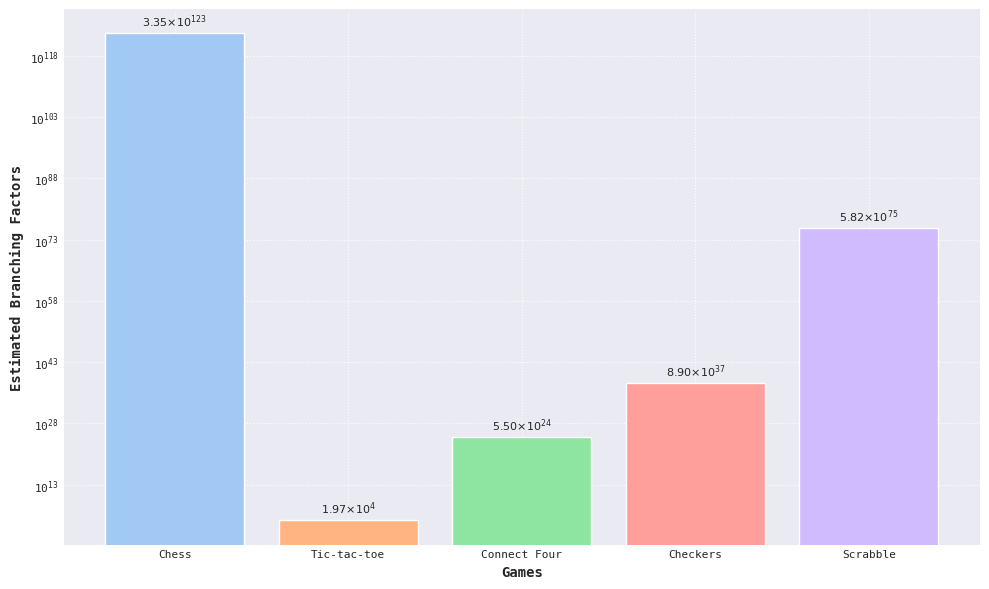

In [5]:
'''
Common Games: Estimated Branching Factors
Visualizes the estimated branching factors for various games using a bar chart.
'''

plt, ax, colors = load_plot()

# Prepare the data
games             = ["Chess", "Tic-tac-toe", "Connect Four", "Checkers", "Scrabble"]
branching_factors = [3.353e123, 19683, 5.5e24, 8.9e37, 5.82e75]

# Create the bar chart
bars = plt.bar(games, branching_factors, color = colors[:5], edgecolor = 'white')

# Add annotations to the top of each bar
for bar, bf in zip(bars, branching_factors):
    height   = bar.get_height()
    exponent = int(np.floor(np.log10(bf)))
    base     = bf / (10 ** exponent)
    ax.annotate(f'${base:.2f} × 10^{{{exponent}}}$',
                xy         = (bar.get_x() + bar.get_width() / 2, height),
                xytext     = (0, 3),
                textcoords = "offset points",
                ha         = 'center', 
                va         = 'bottom',
                fontsize   = 8)

plt.xlabel("Games")
plt.ylabel("Estimated Branching Factors")
plt.gca().set_yscale("log")
plt.tight_layout()

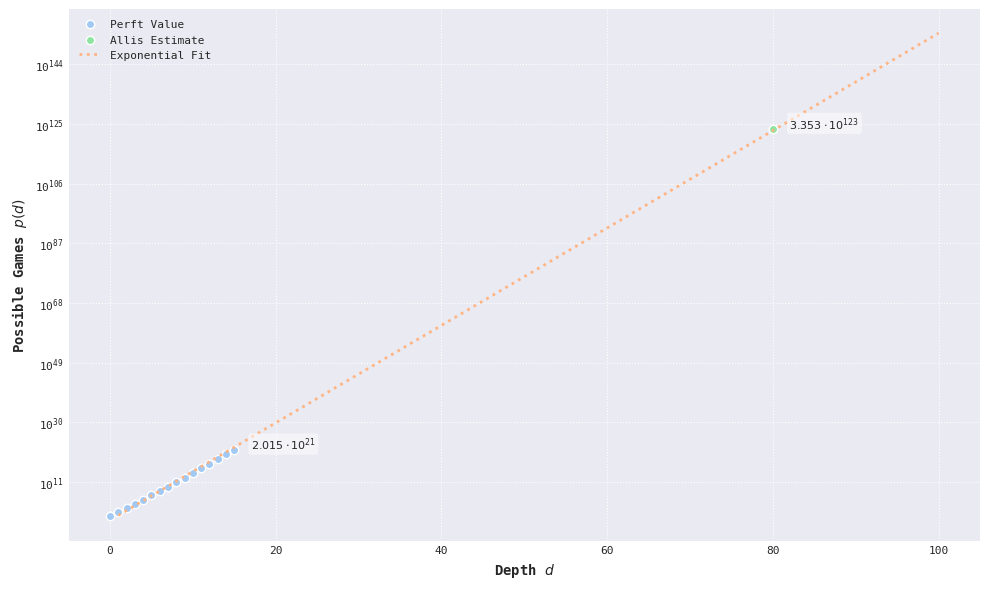

In [6]:
'''
Possible Games (p(d) vs. d)
Visualizes the relationship between the depth (number of half-moves) in a game of chess
and the number of possible unique games using a scatter plot and an exponential fit line.

This script demonstrates how to use linear regression with a logarithmic transformation
to model the exponential growth of possible games in chess as the depth increases.
'''

from sklearn.linear_model import LinearRegression as lr
plt, ax, colors = load_plot()

# Prepare the data
depths      = np.array(list(range(0, 16)) + [80])
positions   = np.array([1, 20, 400, 8902, 197281, 4865609, 119060324, 3195901860, 84998978956, 2439530234167, 69352859712417, 2097651003696806, 62854969236701747, 1981066775000396239, 61885021521585529237, 2015099950053364471960, 3.353e123], dtype = float)
annotations = [((15, 2.015e21), r'$2.015 \cdot 10^{21}$'), ((80, 3.353e123), r'$3.353 \cdot 10^{123}$')]

# Fit the linear regression model and generate predictions for the fit line
model       = lr().fit(depths[:, None], np.log(positions))
depth_range = np.linspace(1, 100, 1000)
predictions = np.exp(model.predict(depth_range[:, None]))

# Create the scatter plot
plt.scatter(depths,   
            positions,   
            color      = colors[0], 
            marker     = 'o', 
            edgecolors = 'white', 
            label      = "Perft Value")

# Isolate the point for the "Allis Estimate"
plt.scatter(np.array([80]),
            np.array([3.353e123]),
            color      = colors[2],
            marker     = 'o',
            edgecolors = 'white',
            label      = "Allis Estimate")

# Create the fit line
plt.plot(depth_range, 
         predictions, 
         color     = colors[1], 
         linestyle = ':', 
         linewidth = 2,       
         label     = "Exponential Fit")

# Add annotations as defined above to the plot
for pos, text in annotations:
    plt.annotate(text, pos, (pos[0] + 2, pos[1] * 1.5), fontsize = 8,
                 bbox = dict(boxstyle  = "round,pad = 0.2", 
                             edgecolor = "none", 
                             facecolor = "white", 
                             alpha     = 0.5))

plt.xlabel("Depth $d$")
plt.ylabel("Possible Games $p(d)$")
plt.legend(loc = 'best')
plt.gca().set(yscale = 'log')
plt.tight_layout()

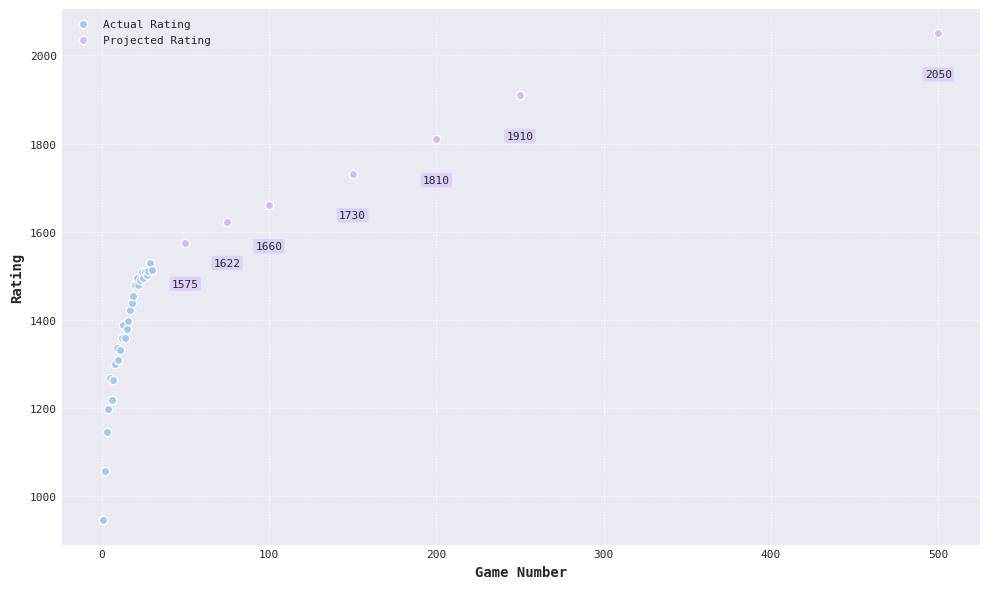

In [7]:
'''
Actual vs. Projected Rating
Visualizes Player A's actual rating change in the first 30 games on a new chess account,
and projects their rating after playing 50, 75, 100, 150, 200, 250, and 500 games using a scatter plot.
'''

plt, ax, colors = load_plot()

game_numbers  = list(range(1, 31))
win_loss      = [2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3]
ratings       = [945, 1057, 1145, 1198, 1267, 1217, 1263, 1300, 1335, 1309, 1332, 1358, 1388, 1358, 1379, 1397, 1421, 1439, 1455, 1480, 1495, 1478, 1490, 1509, 1494, 1509, 1501, 1511, 1528, 1514]

milestones          = [50, 75, 100, 150, 200, 250, 500]
milestone_ratings   = [1575, 1622, 1660, 1730, 1810, 1910, 2050]

# Plot ratings
plt.scatter(game_numbers, 
            ratings, 
            color      = colors[0], 
            marker     = 'o', 
            edgecolors = 'white', 
            label      = 'Actual Rating')

plt.scatter(milestones, 
            milestone_ratings, 
            color      = colors[4], 
            marker     = 'o', 
            edgecolors = 'white', 
            label      = 'Projected Rating')

# Add annotations for Projected Ratings
for idx, (ms, rt) in enumerate(zip(milestones, milestone_ratings)):
    plt.annotate("{:.0f}".format(rt),
                 (ms, rt),
                 xytext   = (ms, rt - 100),
                 ha       = "center",
                 fontsize = 8,
                 bbox     = dict(boxstyle  = "round,pad=0.2",
                                 edgecolor = "none",
                                 facecolor = colors[4],
                                 alpha     = 0.5))

plt.xlabel("Game Number")
plt.ylabel("Rating")
plt.legend(loc = 'best')
plt.tight_layout()

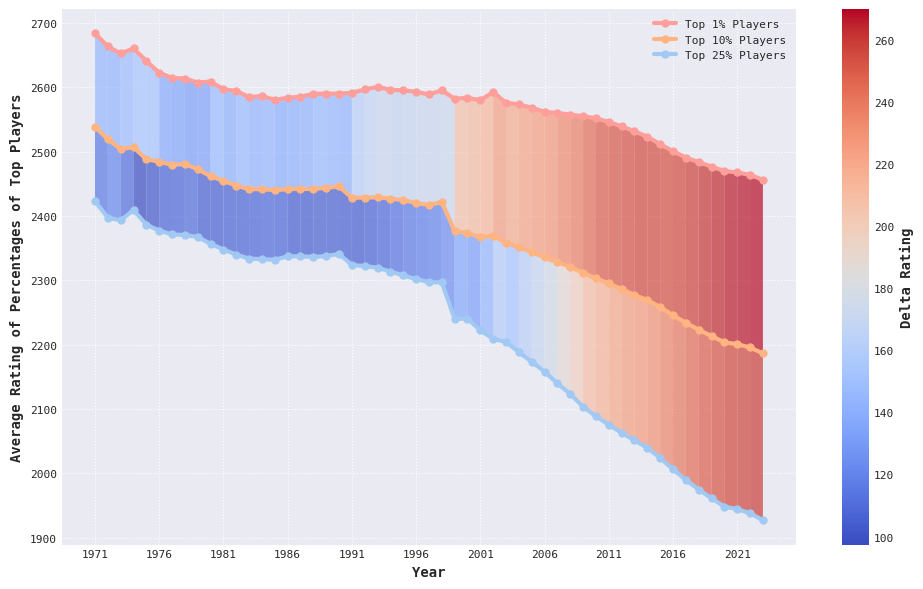

In [8]:
'''
Average FIDE Rating by Year of Each Year's Top N% Players
Plots the average rating by year for each year's top N% players by rating
using a line graph with color coding based on rating deltas.
'''

# Define the percentages to plot
p1 = 1
p2 = 10
p3 = 25

# Calculate the average rating by year for each year's top N% players
def top_percentage(group, percentage):
    top_n = int(len(group) * (percentage / 100))
    return group.nlargest(top_n, 'Rating')

def remove_top_players(group, top_players_list):
    for top_players in top_players_list:
        group = group[~group['Player'].isin(top_players['Player'])]
    return group

top_1 = fide_ratings.groupby('Year').apply(lambda x: top_percentage(x, p1)).reset_index(drop = True)
top_2 = fide_ratings.groupby('Year').apply(lambda x: remove_top_players(x, [top_1])).reset_index(drop = True) \
                    .groupby('Year').apply(lambda x: top_percentage(x, p2)).reset_index(drop = True)
top_3 = fide_ratings.groupby('Year').apply(lambda x: remove_top_players(x, [top_1, top_2])).reset_index(drop = True) \
                    .groupby('Year').apply(lambda x: top_percentage(x, p3)).reset_index(drop = True)

average_top_1 = top_1.groupby('Year')['Rating'].mean().reset_index()
average_top_2 = top_2.groupby('Year')['Rating'].mean().reset_index()
average_top_3 = top_3.groupby('Year')['Rating'].mean().reset_index()

# Find the deltas between the average ratings of top N% players
average_top_1['Delta'] = average_top_1['Rating'] - average_top_2['Rating']
average_top_2['Delta'] = average_top_2['Rating'] - average_top_3['Rating']

# Normalize the deltas to the range [0, 1] for colormap scaling
min_delta = min(average_top_1['Delta'].min(), average_top_2['Delta'].min())
max_delta = max(average_top_1['Delta'].max(), average_top_2['Delta'].max())
norm = Normalize(min_delta, max_delta)

average_top_1['Normalized'] = norm(average_top_1['Delta'])
average_top_2['Normalized'] = norm(average_top_2['Delta'])

# Load the custom plot
plt, ax, colors = load_plot()

# Create the lines
ax.plot(average_top_1['Year'], average_top_1['Rating'], label=f'Top {p1}% Players', color=colors[3], marker='o', markersize=5, linewidth=3)
ax.plot(average_top_2['Year'], average_top_2['Rating'], label=f'Top {p2}% Players', color=colors[1], marker='o', markersize=5, linewidth=3)
ax.plot(average_top_3['Year'], average_top_3['Rating'], label=f'Top {p3}% Players', color=colors[0], marker='o', markersize=5, linewidth=3)

# Fill the area between top_1 and top_2 with color based on the delta
cmap = plt.get_cmap('coolwarm')
for i in range(len(average_top_1) - 1):
    ax.fill_between(
        average_top_1['Year'][i:i+2],
        average_top_1['Rating'][i:i+2],
        average_top_2['Rating'][i:i+2],
        facecolor = cmap(average_top_1['Normalized'][i]),
        alpha = 0.7)

# Fill the area between top_2 and top_3 with color based on the delta
for i in range(len(average_top_2) - 1):
    ax.fill_between(
        average_top_2['Year'][i:i+2],
        average_top_2['Rating'][i:i+2],
        average_top_3['Rating'][i:i+2],
        facecolor = cmap(average_top_2['Normalized'][i]),
        alpha = 0.7)

from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(5))

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel(f'Average Rating of Percentages of Top Players')
ax.legend()

# Add colorbar
sm = ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('Delta Rating')

plt.tight_layout()

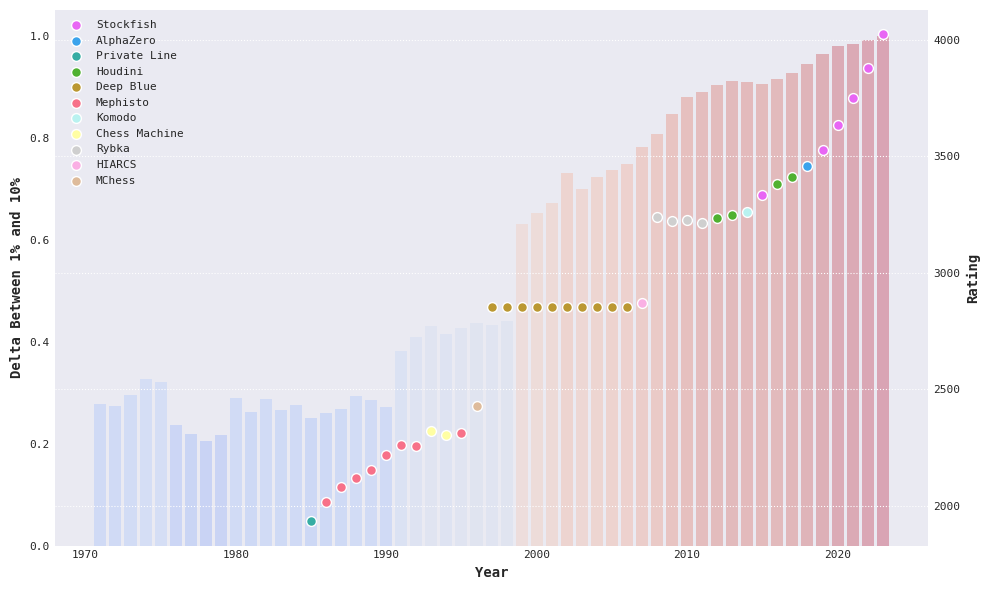

In [9]:
'''
Bot Ratings vs. Delta Ratings of Top 1% Players and 10% Players
Plots the highest recorded rating at January of each year across all major chess engines,
and then uses a bar graph with color coding based on rating deltas to find correlations.
'''

bot_elo_data = [(1985, "Private Line",  1935), (1986, "Mephisto",      2017), (1987, "Mephisto",  2081), (1988, "Mephisto",  2121),
                (1989, "Mephisto",      2154), (1990, "Mephisto",      2220), (1991, "Mephisto",  2263), (1992, "Mephisto",  2259),
                (1993, "Chess Machine", 2322), (1994, "Chess Machine", 2305), (1995, "Mephisto",  2315), (1996, "MChess",    2430),
                (1997, "Deep Blue",     2853), (1998, "Deep Blue",     2853), (1999, "Deep Blue", 2853), (2000, "Deep Blue", 2853),
                (2001, "Deep Blue",     2853), (2002, "Deep Blue",     2853), (2003, "Deep Blue", 2853), (2004, "Deep Blue", 2853),
                (2005, "Deep Blue",     2853), (2006, "Deep Blue",     2853), (2007, "HIARCS",    2871), (2008, "Rybka",     3238),
                (2009, "Rybka",         3224), (2010, "Rybka",         3227), (2011, "Rybka",     3216), (2012, "Houdini",   3237),
                (2013, "Houdini",       3250), (2014, "Komodo",        3259), (2015, "Stockfish", 3334), (2016, "Houdini",   3383),
                (2017, "Houdini",       3411), (2018, "AlphaZero",     3460), (2019, "Stockfish", 3529), (2020, "Stockfish", 3634),
                (2021, "Stockfish",     3751), (2022, "Stockfish",     3880), (2023, "Stockfish", 4023)]

plt, ax, colors = load_plot()

# Convert the 'Year' column of average_top_1 to integers
average_top_1['Year'] = average_top_1['Year'].astype(int)

# Find the unique bot names and assign a unique color to each
unique_bots = list({bot for _, bot, _ in bot_elo_data})
bot_colors  = dict(zip(unique_bots, colors[-len(unique_bots):][::-1]))

# Plot the 'Normalized' values as a bar chart
for _, i in average_top_1.iterrows():
    ax.bar(i['Year'], 
           i['Normalized'], 
           color = cmap(i['Normalized']), 
           alpha = .3)

# Plot the bot data as a scatter plot
ax2 = ax.twinx()
for bot in unique_bots:
    data = [(t[0], t[2]) for t in bot_elo_data if t[1] == bot]
    ax2.scatter(*zip(*data),
               label      = bot, 
               color      = bot_colors[bot], 
               marker     = 'o',
               edgecolors = '1',
               s          = 50) 
    
# Customize the plot
ax.set_ylabel('Delta Between 1% and 10%')
ax.set_xlabel('Year')
ax.grid(False)
ax2.set_ylabel('Rating')
ax2.legend(loc = 'upper left')
plt.tight_layout()